In [87]:
# first, we'll import the relevent packages

# these help us work with the data
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# this is for standardizing in preperation for modeling
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# these take care of cross-validation and the test-train split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV 

# our ML methods
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF

# for performance evaluation of the model
import sklearn.metrics as m

# for model interpretation
from sklearn.tree import plot_tree
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)
# for various plots
from sklearn import tree # the decision tree

# modeling infrastructure
from sklearn.pipeline import Pipeline

In [2]:
# first we load the data
data = pd.read_csv('data.csv')

In [3]:
# look at the data frame
data.shape

(5470, 43)

In [4]:
# look at the column values
data.columns

Index(['State', 'District', 'Congress', 'Representative', 'Party',
       'Incumbancy', 'Trifecta', 'Partisanship_Elected', 'President_Democrat',
       'Midterm_Next', 'Approval_Election', 'Disapproval_Election',
       'Approval_Current', 'Disapproval_Current', 'Reelected', 'Same_Party',
       'totalHouseholds', 'prcntBA', 'prcntHS', 'prcntAsian', 'prcntBlack',
       'prcntHisp', 'prcntWhiteAll', 'lastName', 'firstName', 'middleName',
       'age', 'gender', 'numberTerms', 'daysServed', 'fracServed', 'cd',
       'statenm', 'dwnom1', 'dwnom2', 'black', 'hispanic', 'numSpon',
       'numCosp', 'numPassH', 'numEnact', 'passPrcnt', 'partyControl'],
      dtype='object')

In [5]:
data.dtypes[:50]

State                    object
District                float64
Congress                  int64
Representative           object
Party                     int64
Incumbancy                int64
Trifecta                  int64
Partisanship_Elected      int64
President_Democrat        int64
Midterm_Next              int64
Approval_Election       float64
Disapproval_Election    float64
Approval_Current        float64
Disapproval_Current     float64
Reelected                 int64
Same_Party                int64
totalHouseholds         float64
prcntBA                 float64
prcntHS                 float64
prcntAsian              float64
prcntBlack              float64
prcntHisp               float64
prcntWhiteAll           float64
lastName                 object
firstName                object
middleName               object
age                     float64
gender                   object
numberTerms             float64
daysServed              float64
fracServed              float64
cd      

In [6]:
# we create lists with subsets of the variables
numeric_variables = ['Incumbancy',
                     'Partisanship_Elected',
                     'Approval_Election',
                     'Disapproval_Election',
                     'Approval_Current',
                     'Disapproval_Current',
                     'totalHouseholds',
                     'prcntBA',
                     'prcntHS',
                     'prcntAsian',
                     'prcntBlack',
                     'prcntHisp',
                     'prcntWhiteAll',
                     'age'
                    ]
dropped_variables = [
    'Representative',
    'lastName',
    'firstName',
    'middleName',
    'numberTerms',
    'daysServed',
    'fracServed',
    'cd',
    'statenm', 
    'dwnom1',
    'dwnom2',
    'Party',
    'passPrcnt',
    'numEnact',
    'numPassH',
    'numSpon',
    'numCosp',
    'Congress'
]
binary_variables = [
    'Trifecta',
    'Party',
    'President_Democrat',
    'Midterm_Next',
    'Same_Party',
    'gender',
    'black',
    'hispanic'
]
dummy_variables = [
    'State',
    'District',
    'partyControl'
]

In [7]:
# drop te variables we do not aim to consider
data = data.drop(columns = dropped_variables)

In [8]:
# assign variables to dependent and independent status
y = data[['Reelected']]
X = data.drop('Reelected', axis = 'columns')

In [9]:
# generate test and train data sets
train_X, test_X, train_y, test_y =  train_test_split(X,y,test_size=.25,random_state=88888888)

In [10]:
# verify the size of each data frame
print(train_X.shape[0]/data.shape[0])
print(test_X.shape[0]/data.shape[0])

0.749908592321755
0.25009140767824495


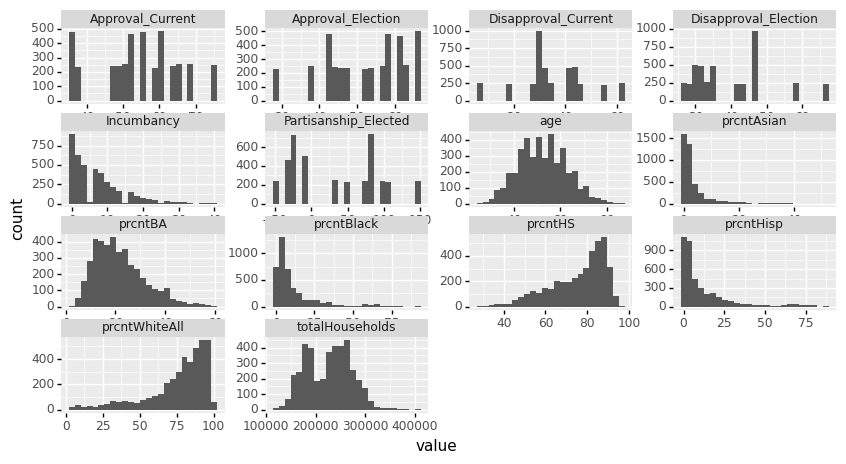

<ggplot: (203218539635)>

In [11]:
# visualize our numerical variables
visual_1 = train_X[numeric_variables].melt()
(
    ggplot(visual_1,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

In [12]:
# we create a list of variables that could need to be altered for skewness
check_log = [
    'prcntAsian',
    'prcntBA',
    'prcntBlack',
    'prcntHS',
    'prcntHisp',
    'prcntWhiteAll'
]

In [13]:
check_log_rename = ['ln_' + x for x in check_log]

In [14]:
data['prcntBlack'].min()

0.012149054

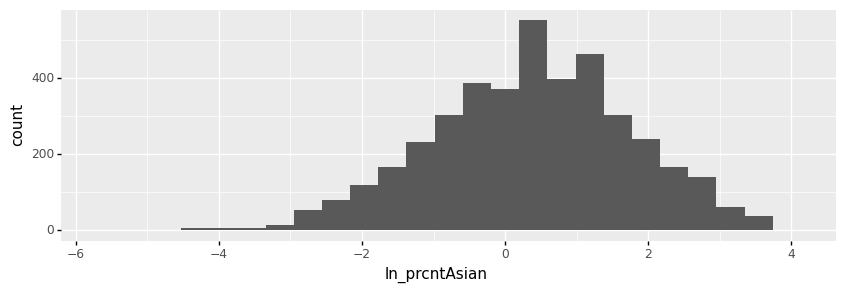

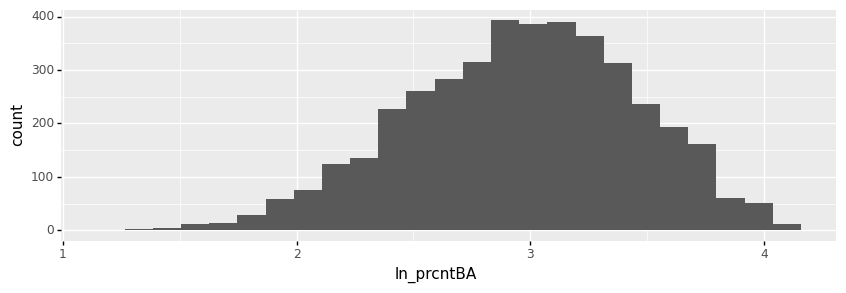

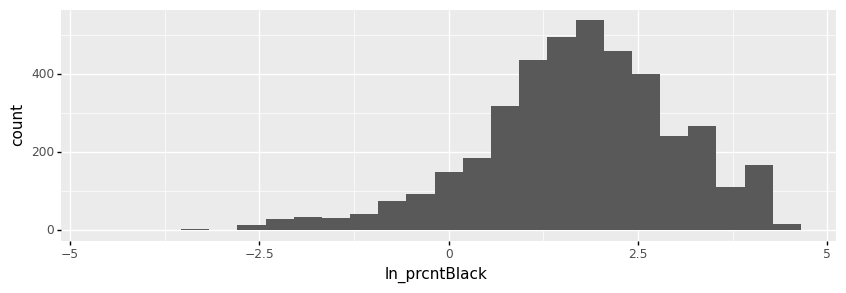

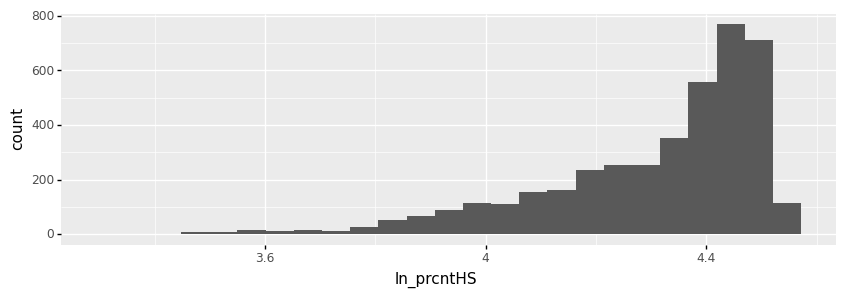

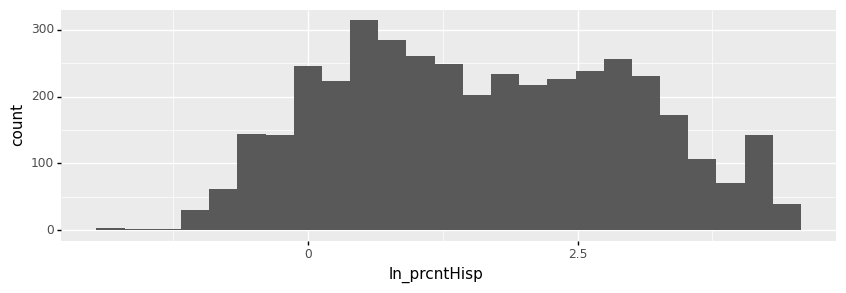

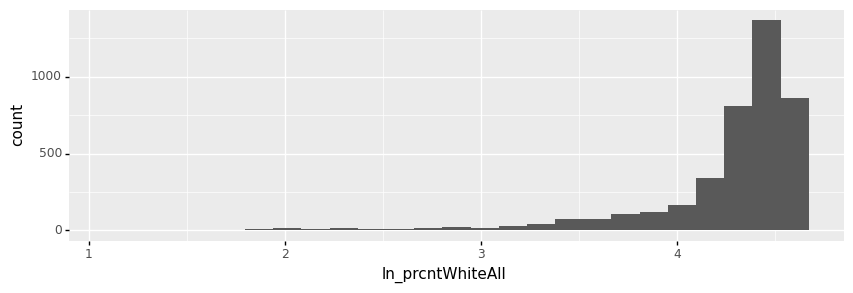

In [15]:
d = train_X.copy(deep=True)
d[check_log_rename] =  np.log(d[check_log])

for var in check_log_rename: 
    print(
        ggplot(d,aes(x= var)) +
        geom_histogram(bins=25) +
        theme(figure_size=(10,3),
              subplots_adjust={'wspace':0.25})
    )


In [16]:
# upon seeing the variables that are normalized, we create a list of variables that should be logged
variables_for_log = [
    'prcntHisp',
    'prcntBlack',
    'prcntBA',
    'prcntAsian',
]

#create new variables names
variable_names_for_log = ['ln_' + x for x in variables_for_log]

In [17]:
# now we establish the preprocessing
def data_process(X):
    """
    this function standardizes the processing of our training and test data, creating dummies and standardizing our numerical variables.
    
    arguments:
        X:
            pandas data frame with columns referenced
    returns:
        a list of pandas data frames, training first and testing second.
    """
    # first we log the relevant variables
    X[variable_names_for_log] =  np.log(X[variables_for_log])
    X = X.drop(columns = variables_for_log)
    
    # we make dummy variables of length k-1 for our categorical variables
    # we do the same with time, which appears as discrete categories
    X = pd.get_dummies(X,
                             columns = dummy_variables, # list of categorical variables
                             drop_first = True) # so we have k-1
    X['gender'] = 1*(X['gender'] == 'M')
    
    for column in X.columns:
        try:
            X[column] = X[column].astype(int)
        except:
            pass
    # we remove Na values
    X = X.dropna()
    
    return X

In [18]:
# now we re load the data and complete the high level processing before resplitting

data = pd.read_csv('data.csv')
data = data.drop(columns = dropped_variables)
data = data_process(data)
y = data[['Reelected']]
X = data.drop('Reelected', axis = 'columns')
train_X, test_X, train_y, test_y =  train_test_split(X,y,test_size=.25,random_state=88888888)

In [19]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=88888888)

In [33]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [34]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,15,25,50,100,150]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4,5,10,25,50]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,4,6,8,12,16],
    'model__n_estimators':[500,1000,1500]}
    
]

In [37]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='balanced_accuracy',
                      n_jobs=4)

In [59]:
search2 = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [60]:
search2.fit(train_X,train_y.Reelected)

GridSearchCV(cv=KFold(n_splits=10, random_state=88888888, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 15, 25, 50, 100, 150]},
                         {'model': [DecisionTreeClassifier(max_depth=25)],
                          'model__max_depth': [2, 3, 4, 5, 10, 25, 50]},
                         {'model': [RandomForestClassifier(max_depth=16,
                                                           n_estimators=1500)],
                          'model__max_depth': [2, 4, 6, 8, 12, 16],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [62]:
rf_mod2 = search2.best_estimator_

In [63]:
rf_mod2

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=16, n_estimators=1500))])

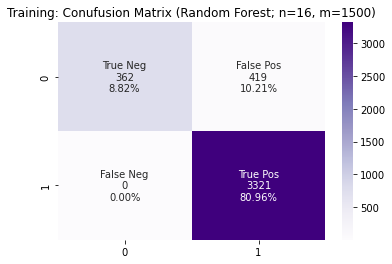

In [72]:
cf_matrix2 = m.confusion_matrix(train_y,rf_mod2.predict(train_X))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix2.flatten()/np.sum(cf_matrix2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.axes()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples', ax = ax)
ax.set_title('Training: Conufusion Matrix (Random Forest; n=16, m=1500)')
plt.show()

In [38]:
search.fit(train_X,train_y.Reelected)

GridSearchCV(cv=KFold(n_splits=10, random_state=88888888, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 15, 25, 50, 100, 150]},
                         {'model': [DecisionTreeClassifier(max_depth=25)],
                          'model__max_depth': [2, 3, 4, 5, 10, 25, 50]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 4, 6, 8, 12, 16],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='balanced_accuracy')

In [24]:
search.param_grid.__getitem__

<function list.__getitem__>

In [45]:
rf_mod = search.best_estimator_

In [50]:
search.best_estimator_

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model', DecisionTreeClassifier(max_depth=25))])

In [26]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.9991097663146215

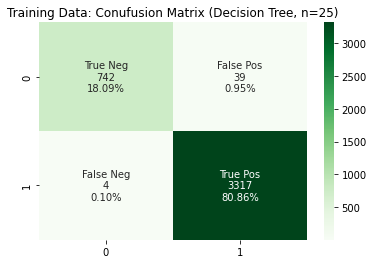

In [71]:
cf_matrix = m.confusion_matrix(train_y,rf_mod.predict(train_X))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.axes()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens', ax = ax)
ax.set_title('Training Data: Conufusion Matrix (Decision Tree, n=25)')
plt.show()

In [76]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=10)

In [80]:
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

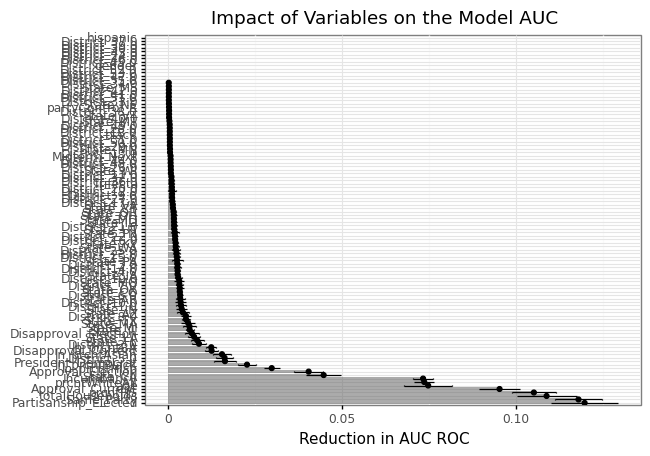

<ggplot: (203222035466)>

In [81]:
(
    ggplot(vi_dat[vi_dat['vi']>0],
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="") +
    ggtitle('Impact of Variables on the Model AUC') # for the main title
)

<Figure size 3600x3600 with 0 Axes>

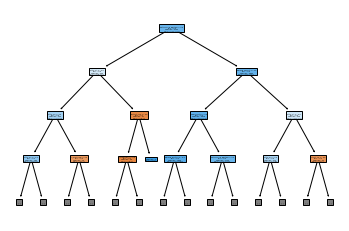

<Figure size 3600x3600 with 0 Axes>

In [111]:
plt.figure()
plot_tree(
    search.best_estimator_['model'],  # <-- added indexing here
    max_depth=3,
    impurity=True,
    feature_names=train_X.columns,   # changed this argument to make it work properly
    precision=1,
    filled=True
);
plt.figure(figsize=(50,50))  # set plot size (denoted in inches)

In [96]:
search.best_estimator_

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model', DecisionTreeClassifier(max_depth=25))])

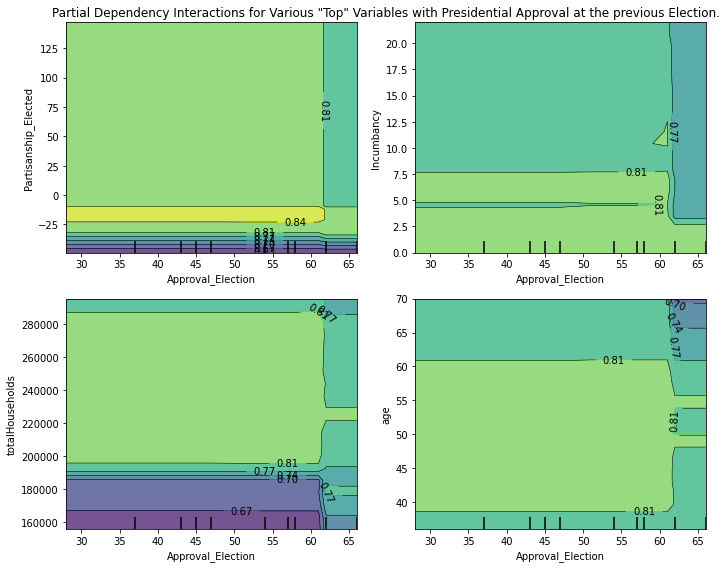

In [117]:
# Feed in the ineraction as a nested list
interacted_features = [['Approval_Election','Partisanship_Elected'],['Approval_Election','Incumbancy'],['Approval_Election','totalHouseholds'],['Approval_Election','age'] ] 

# Then business as usual when plotting
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Partial Dependency Interactions for Various "Top" Variables with Presidential Approval at the previous Election.' )
display = plot_partial_dependence(
    rf_mod, train_X, interacted_features,
    n_cols=2, n_jobs=4, grid_resolution=20,ax=ax
)
fig.tight_layout()

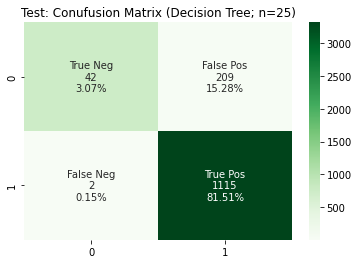

In [79]:
cf_matrix3 = m.confusion_matrix(test_y,rf_mod2.predict(test_X))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix3.flatten()/np.sum(cf_matrix3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.axes()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens', ax = ax)
ax.set_title('Test: Conufusion Matrix (Decision Tree; n=25)')
plt.show()

In [118]:
train_X.columns

Index(['Incumbancy', 'Trifecta', 'Partisanship_Elected', 'President_Democrat',
       'Midterm_Next', 'Approval_Election', 'Disapproval_Election',
       'Approval_Current', 'Disapproval_Current', 'Same_Party',
       ...
       'District_45.0', 'District_46.0', 'District_47.0', 'District_48.0',
       'District_49.0', 'District_50.0', 'District_51.0', 'District_52.0',
       'District_53.0', 'partyControl_R'],
      dtype='object', length=106)

In [121]:
data.columns[:25]

Index(['Incumbancy', 'Trifecta', 'Partisanship_Elected', 'President_Democrat',
       'Midterm_Next', 'Approval_Election', 'Disapproval_Election',
       'Approval_Current', 'Disapproval_Current', 'Reelected', 'Same_Party',
       'totalHouseholds', 'prcntHS', 'prcntWhiteAll', 'age', 'gender', 'black',
       'hispanic', 'ln_prcntHisp', 'ln_prcntBlack', 'ln_prcntBA',
       'ln_prcntAsian', 'State_AR', 'State_AZ', 'State_CA'],
      dtype='object')